# Product Image Recognition

# Pure Customised CNN

This is without transfer learning.

In [1]:
from __future__ import print_function, division

#general operations
import time
import os
import copy
import pathlib

#for openning images via an URL
from PIL import Image
import requests

#data processing
import pandas as pd
import numpy as np

#data visualisation
import matplotlib.pyplot as plt

#ML tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import models, transforms
import torch.nn.functional as F

## Data Cleaning and Structuring

In [2]:
from empdata import *

In [3]:
elecdata = EmpImageData(os.path.join('tabular data', 'elec_final.csv'))

In [4]:
elecdata.create_dataset('LABEL','PRODUCT_ID','data/eg_data');

There are in total 0 missing data.


In [5]:
elecdata.classes_num

37

## Create Dataset Object

In [6]:
#setting up the image transformation
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
datasets_loader, dataset_sizes = elecdata.mktorchdataloaders(transformations=transformations)

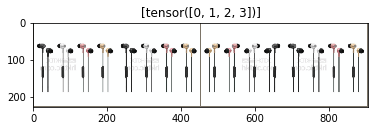

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(datasets_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes])

In [9]:
print(inputs.size())

torch.Size([4, 3, 224, 224])


## Defining Model and Training Procedure

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    train_record=[]
    val_record=[]
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in datasets_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_record.append([epoch_loss,epoch_acc])
            else:
                val_record.append([epoch_loss,epoch_acc])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            print('\n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_record, val_record

In [11]:
class ConsumerElectronicModel(nn.Module):
    def __init__(self):
        super(ConsumerElectronicModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(56 * 56 * 16, 60)
        self.fc2 = nn.Linear(60, elecdata.classes_num)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
torch.cuda.is_available()

True

In [14]:
model_ft = ConsumerElectronicModel()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft, t_record, v_record = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
train Loss: 2.9191 Acc: 0.2307


val Loss: 2.9050 Acc: 0.2401


Epoch 1/11
----------
train Loss: 2.7248 Acc: 0.2360


val Loss: 2.7905 Acc: 0.2411


Epoch 2/11
----------
train Loss: 2.5536 Acc: 0.2440


val Loss: 2.8460 Acc: 0.2369


Epoch 3/11
----------
train Loss: 2.4113 Acc: 0.2565


val Loss: 2.8433 Acc: 0.2388


Epoch 4/11
----------
train Loss: 2.2937 Acc: 0.2657


val Loss: 2.8659 Acc: 0.2392


Epoch 5/11
----------
train Loss: 2.2147 Acc: 0.2744


val Loss: 2.9563 Acc: 0.2288


Epoch 6/11
----------
train Loss: 2.1300 Acc: 0.2856


val Loss: 3.0129 Acc: 0.2230


Epoch 7/11
----------
train Loss: 2.0467 Acc: 0.3031


val Loss: 2.9672 Acc: 0.2285


Epoch 8/11
----------
train Loss: 1.9822 Acc: 0.3037


val Loss: 2.9695 Acc: 0.2356


Epoch 9/11
----------
train Loss: 1.9404 Acc: 0.3111


val Loss: 2.9771 Acc: 0.2346


Epoch 10/11
----------


In [ ]:
torch.save(model_ft, 'model_cus_elec.pth')

## Model Evaluation

In [30]:
import matplotlib.pyplot as plt
def plot_graph(t, v, gtype='loss'):
    
    if gtype != 'loss':
        ind = 1
        gtype = 'accuracy'
    else:
        ind = 0
        
    periods=len(t_record)
    x=np.arange(0,periods)
    
    train=[x[ind] for x in t]
    val=[x[ind] for x in v]
    
    plt.plot(x,train)
    plt.plot(x,val)
    
    plt.legend(['train','val'])
    plt.title('{}: Train vs Validation'.format(gtype))
    plt.ylabel(gtype)
    plt.xlabel('Epoch')

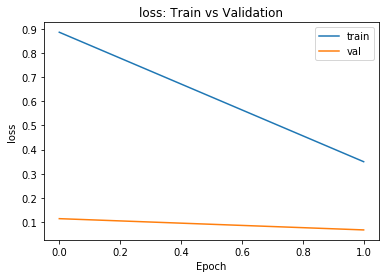

In [52]:
plot_graph(t_record, v_record)

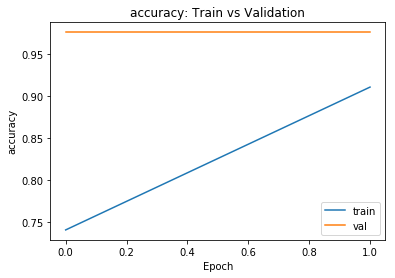

In [53]:
plot_graph(t_record, v_record, gtype='accuracy')

In [54]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(datasets_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(reverse_mapping[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [55]:
visualize_model(model_ft)

NameError: name 'model_ft' is not defined

In [70]:
def visualise_online_model(model):
    num_images=len(test_set)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, inputs in enumerate(testset_loader):
            inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(reverse_mapping[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [78]:
#add a list of URL photos here
test_images_online=[]

In [72]:
#creating our own customised data
class productData_test(Dataset):
    def __init__(self, urls, transforms=None):
        self.urls = urls
        self.transforms = transforms
        self.data_len = len(self.urls)
    
    def __getitem__(self, index):
        response=requests.get(self.urls[index])
        img=Image.open(BytesIO(response.content)).convert('RGB')
        transformed_img = transformations(img)
        feed_it_in.append(transformed_img) 
        return transformed_img
    
    def __len__(self):
        return self.data_len

In [73]:
test_set = productData_test(urls=test_images_online, transforms=transformations)
testset_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                batch_size=4,
                                                shuffle=False)